In [7]:
import pandas as pd

# Load csv (same folder)
df = pd.read_csv("iris_data.csv")

# Remove rows with id == 0
df = df[df["Unnamed: 0"] != 0].reset_index(drop=True)

df.head()


,Unnamed: 0,sepal_width,sepal_length,petal_width,petal_length,type
0,1,4.9,3.0,1.4,0.2,0
1,2,4.7,3.2,1.3,0.2,0
2,3,4.6,3.1,1.5,0.2,0
3,4,5.0,3.6,1.4,0.2,0
4,5,5.4,3.9,1.7,0.4,0


In [8]:
import random
import numpy as np
import torch

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

set_seed(42)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Use only two features (easy to visualize)
X = df[["sepal_length", "sepal_width"]].values

# Use only two classes (binary classification)
y = df["type"].values
mask = y < 2          # keep class 0 and 1 only
X = X[mask]
y = y[mask]

# 80 / 10 / 10 split
X_train, X_tmp, y_train, y_tmp = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y # make sure to keep class distribution in splits
)

X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.5, random_state=42, stratify=y_tmp
)

# Standardization (fit on train only)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)

X_train.shape, X_val.shape, X_test.shape



((79, 2), (10, 2), (10, 2))

In [21]:
X_test

array([[ 0.27664393, -1.23837557],
       [-0.14772249, -0.11755447],
       [-1.20863853,  0.20268013],
       [ 0.48882714, -0.59790637],
       [-1.63300494, -0.75802367],
       [ 1.33755997, -0.59790637],
       [ 1.54974318, -0.59790637],
       [ 0.48882714, -0.75802367],
       [-0.14772249,  1.80385312],
       [-0.35990569,  1.00326663]])

In [15]:
import torch
from torch.utils.data import Dataset, DataLoader

class IrisDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


train_loader = DataLoader(IrisDataset(X_train, y_train), batch_size=16, shuffle=True)
val_loader   = DataLoader(IrisDataset(X_val, y_val), batch_size=32)
test_loader  = DataLoader(IrisDataset(X_test, y_test), batch_size=32)


In [16]:
import torch.nn as nn

class LinearClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(2, 2)  # 2 features, 2 classes

    def forward(self, x):
        return self.linear(x)


model = LinearClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)


In [ ]:
def train(model, loader, epochs=200):
    for epoch in range(epochs):
        for X_batch, y_batch in loader:
            optimizer.zero_grad() 
            logits = model(X_batch)
            loss = criterion(logits, y_batch)
            loss.backward()
            optimizer.step()

        if epoch % 50 == 0:
            print(f"Epoch {epoch}, loss = {loss.item():.4f}")


train(model, train_loader)


Epoch 0, loss = 0.9255
Epoch 50, loss = 0.0278
Epoch 100, loss = 0.0191
Epoch 150, loss = 0.0150


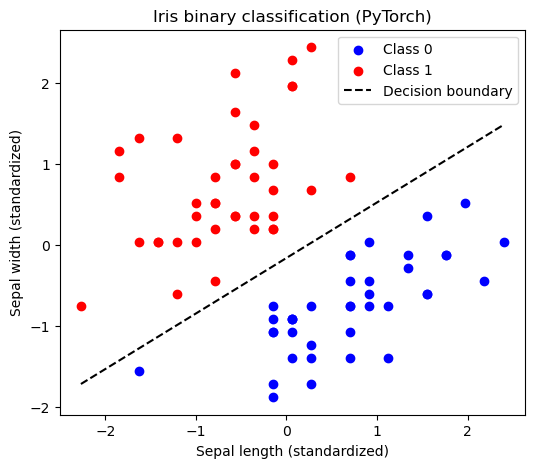

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Convert training data to numpy
X_plot = X_train
y_plot = y_train

# Scatter plot
plt.figure(figsize=(6, 5))
plt.scatter(X_plot[y_plot == 0][:, 0], X_plot[y_plot == 0][:, 1],
            color="blue", label="Class 0")
plt.scatter(X_plot[y_plot == 1][:, 0], X_plot[y_plot == 1][:, 1],
            color="red", label="Class 1")

# Get classifier parameters: w1*x + w2*y + b = 0
W = model.linear.weight.detach().numpy()
b = model.linear.bias.detach().numpy()

# Decision boundary between class 0 and 1
w = W[0] - W[1]
bias = b[0] - b[1]

x_vals = np.linspace(X_plot[:, 0].min(), X_plot[:, 0].max(), 100)
y_vals = -(w[0] * x_vals + bias) / w[1]

plt.plot(x_vals, y_vals, "k--", label="Decision boundary")

plt.xlabel("Sepal length (standardized)")
plt.ylabel("Sepal width (standardized)")
plt.legend()
plt.title("Iris binary classification (PyTorch)")
plt.show()


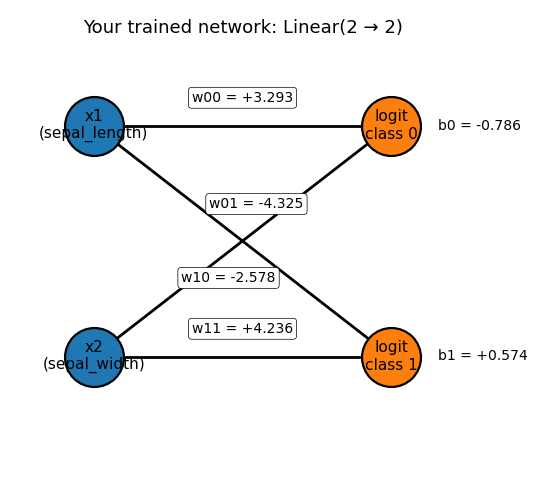

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

W = model.linear.weight.detach().cpu().numpy()  # shape (2,2)
b = model.linear.bias.detach().cpu().numpy()    # shape (2,)

inputs  = ["x1\n(sepal_length)", "x2\n(sepal_width)"]
outputs = ["logit\nclass 0", "logit\nclass 1"]

# Positions (more vertical spacing + more margin)
x_in, x_out = 0.18, 0.82
y_in  = [0.75, 0.25]
y_out = [0.75, 0.25]

fig, ax = plt.subplots(figsize=(6, 6))  # square-ish
ax.set_axis_off()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

# Draw nodes (circles)
node_style = dict(s=1800, edgecolors="black", linewidths=1.6, zorder=3)
ax.scatter([x_in]*2,  y_in,  **node_style)
ax.scatter([x_out]*2, y_out, **node_style)

# Node labels
for i, name in enumerate(inputs):
    ax.text(x_in, y_in[i], name, ha="center", va="center", fontsize=11, zorder=4)

for j, name in enumerate(outputs):
    ax.text(x_out, y_out[j], name, ha="center", va="center", fontsize=11, zorder=4)


label_offset = {
    (0, 0): (+0.00, +0.06),   # w00
    (0, 1): (+0.03, +0.08),   # w01  
    (1, 0): (-0.03, -0.08),   # w10
    (1, 1): (+0.00, +0.06),   # w11
}

# Draw edges and annotate weights
for j in range(2):      # output index
    for i in range(2):  # input index
        ax.plot(
            [x_in, x_out],
            [y_in[i], y_out[j]],
            linewidth=2.0,
            color="black",
            zorder=1
        )

        xm = (x_in + x_out) / 2
        ym = (y_in[i] + y_out[j]) / 2
        dx, dy = label_offset[(j, i)]

        ax.text(
            xm + dx,
            ym + dy,
            f"w{j}{i} = {W[j,i]:+.3f}",
            ha="center",
            va="center",
            fontsize=10,
            bbox=dict(
                boxstyle="round,pad=0.25",
                fc="white",
                ec="black",
                linewidth=0.5
            ),
            zorder=10   
        )


# Bias near output nodes (a bit to the right)
for j in range(2):
    ax.text(
        x_out + 0.10, y_out[j],
        f"b{j} = {b[j]:+.3f}",
        ha="left", va="center",
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.85),
        zorder=5
    )

ax.text(0.5, 0.95, "Your trained network: Linear(2 → 2)", ha="center", fontsize=13)
plt.show()
